### <center>Quantitative Asset Management - MGMTMFE 431 - Lec 3</center>
### <center>Final Project</center>
### <center>Quality Minus Junk</center>
#### <center>Submitted by - Ashutosh Ekade, Gaurav Sharma, Lixiong He, Yakun Niu</center>

In [1]:
import os
os.getcwd()
import numpy as np
import wrds
from random import *
import pandas as pd
from scipy import stats
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import pandas_datareader
from pandas.tseries.offsets import *
from dateutil.relativedelta import *
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
from scipy.optimize import minimize_scalar
from scipy.optimize import least_squares
import datetime
import statsmodels.api as sm

id_wrds = 'lixonhlx'

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

### QMJ data fetch from WRDS

In [2]:
########################################################################################################################
## Compustat (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
cstat = conn.raw_sql("""
                    select a.gvkey, a.datadate, a.fyear, a.revt, a.cogs, a.at, 
                    a.ni, a.pstkl, a.txditc, a.ceq, a.lt, 
                    a.mib, a.itcb, a.txdb, a.pstkrv, a.seq, a.pstk, 
                    a.dp, a.wcap, a.wcapch, a.capx, a.dltt, a.dlc, a.mibt,
                    a.re, a.ebit, a.sale, a.csho, a.prcc_f, a.prcc_c, b.sic, b.naics
                    from comp.funda as a
                    left join comp.names as b
                    on a.gvkey = b.gvkey
                    where indfmt='INDL'
                    and datafmt='STD'
                    and popsrc='D'
                    and consol='C'
                    """)
conn.close()

Loading library list...
Done


In [3]:
cstat

,gvkey,datadate,fyear,revt,cogs,at,ni,pstkl,txditc,ceq,...,dlc,mibt,re,ebit,sale,csho,prcc_f,prcc_c,sic,naics
0,001000,1961-12-31,1961.0,0.900,NaN,NaN,NaN,0.0,0.000,NaN,...,NaN,0.000,NaN,NaN,0.900,0.152,NaN,NaN,3089,None
1,001000,1962-12-31,1962.0,1.600,NaN,NaN,NaN,0.0,NaN,0.552,...,NaN,0.000,NaN,NaN,1.600,0.181,NaN,9.00,3089,None
2,001000,1963-12-31,1963.0,1.457,1.065,NaN,0.003,0.0,0.008,0.553,...,NaN,0.000,0.052,0.000,1.457,0.186,NaN,10.75,3089,None
3,001000,1964-12-31,1964.0,2.032,1.474,1.416,0.052,0.0,0.020,0.607,...,0.088,0.000,0.001,0.074,2.032,0.196,NaN,12.25,3089,None
4,001000,1965-12-31,1965.0,1.688,1.342,2.310,-0.197,0.0,0.000,0.491,...,0.300,0.000,-0.196,-0.242,1.688,0.206,NaN,NaN,3089,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72092,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5812,72251
72093,355398,2022-12-31,2022.0,558.225,418.322,576.112,-41.248,0.0,3.611,239.806,...,40.091,2.231,-254.677,6.665,558.225,61.933,NaN,NaN,5812,72251
72094,355398,2023-12-31,2023.0,686.362,503.963,576.883,25.653,0.0,1.347,270.086,...,38.998,2.035,-224.397,35.404,686.362,61.933,NaN,NaN,5812,72251
72095,356128,2022-12-31,2022.0,2746.982,224.521,11072.847,1264.809,0.0,7.016,1771.010,...,135.330,14.105,1628.610,2160.348,2746.982,190.310,66.0,66.00,6141,522291


In [4]:
compustat_data = cstat.copy()
# converting all accounting variables by multiplying by 1000000
cols_to_multiply = compustat_data.columns[3:-4]
compustat_data[cols_to_multiply] = compustat_data[cols_to_multiply] * 1000000
compustat_data


,gvkey,datadate,fyear,revt,cogs,at,ni,pstkl,txditc,ceq,...,dlc,mibt,re,ebit,sale,csho,prcc_f,prcc_c,sic,naics
0,001000,1961-12-31,1961.0,9.000000e+05,NaN,NaN,NaN,0.0,0.0,NaN,...,NaN,0.0,NaN,NaN,9.000000e+05,152000.0,NaN,NaN,3089,None
1,001000,1962-12-31,1962.0,1.600000e+06,NaN,NaN,NaN,0.0,NaN,5.520000e+05,...,NaN,0.0,NaN,NaN,1.600000e+06,181000.0,NaN,9.00,3089,None
2,001000,1963-12-31,1963.0,1.457000e+06,1065000.0,NaN,3.000000e+03,0.0,8000.0,5.530000e+05,...,NaN,0.0,5.200000e+04,0.000000e+00,1.457000e+06,186000.0,NaN,10.75,3089,None
3,001000,1964-12-31,1964.0,2.032000e+06,1474000.0,1.416000e+06,5.200000e+04,0.0,20000.0,6.070000e+05,...,88000.0,0.0,1.000000e+03,7.400000e+04,2.032000e+06,196000.0,NaN,12.25,3089,None
4,001000,1965-12-31,1965.0,1.688000e+06,1342000.0,2.310000e+06,-1.970000e+05,0.0,0.0,4.910000e+05,...,300000.0,0.0,-1.960000e+05,-2.420000e+05,1.688000e+06,206000.0,NaN,NaN,3089,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5812,72251
72092,355398,2022-12-31,2022.0,5.582250e+08,418322000.0,5.761120e+08,-4.124800e+07,0.0,3611000.0,2.398060e+08,...,40091000.0,2231000.0,-2.546770e+08,6.665000e+06,5.582250e+08,61933000.0,NaN,NaN,5812,72251
72093,355398,2023-12-31,2023.0,6.863620e+08,503963000.0,5.768830e+08,2.565300e+07,0.0,1347000.0,2.700860e+08,...,38998000.0,2035000.0,-2.243970e+08,3.540400e+07,6.863620e+08,61933000.0,NaN,NaN,5812,72251
72094,356128,2022-12-31,2022.0,2.746982e+09,224521000.0,1.107285e+10,1.264809e+09,0.0,7016000.0,1.771010e+09,...,135330000.0,14105000.0,1.628610e+09,2.160348e+09,2.746982e+09,190310000.0,66.0,66.00,6141,522291


In [5]:
compustat_data.rename(columns={'datadate': 'date'}, inplace=True)
compustat_data['date'] = pd.to_datetime(compustat_data['date'])
compustat_data['she'] = np.where(compustat_data['seq'].notna(), compustat_data['seq'],
             np.where(compustat_data['ceq'].notna() & compustat_data['pstk'].notna(), compustat_data['ceq'] + compustat_data['pstk'],
             np.where(compustat_data['at'].notna() & compustat_data['lt'].notna() & compustat_data['mib'].notna(), compustat_data['at'] - compustat_data['lt'] - compustat_data['mib'],
             np.where(compustat_data['at'].notna() & compustat_data['lt'].notna(), compustat_data['at'] - compustat_data['lt'],
             0))))

compustat_data['dt'] = np.where(compustat_data['txditc'].notna(), compustat_data['txditc'],
             np.where(compustat_data['itcb'].notna() & compustat_data['txdb'].notna(), compustat_data['itcb'] + compustat_data['txdb'],
             np.where(compustat_data['itcb'].notna(), compustat_data['itcb'],
             np.where(compustat_data['txdb'].notna(), compustat_data['txdb'],
             0))))

compustat_data['ps'] = np.where(compustat_data['pstkrv'].notna(), compustat_data['pstkrv'],
             np.where(compustat_data['pstkl'].notna(), compustat_data['pstkl'],
             np.where(compustat_data['pstk'].notna(), compustat_data['pstk'],
             0)))

compustat_data[['dp', 'wcapch', 'capx']] = compustat_data[['dp', 'wcapch', 'capx']].fillna(0)

compustat_data['be'] = (compustat_data['she'] - compustat_data['ps'] + compustat_data['dt'])
compustat_data['gp'] = compustat_data['revt'].abs() - compustat_data['cogs']
compustat_data['gpoa'] = np.where(compustat_data['at'] == 0, np.nan, (compustat_data['revt'].abs() - compustat_data['cogs']) / compustat_data['at'])
compustat_data['roe'] = np.where(compustat_data['be'] == 0, np.nan, compustat_data['ni'] / compustat_data['be'].abs())
compustat_data['roa'] = np.where(compustat_data['at'] == 0, np.nan, compustat_data['ni'] / compustat_data['at'])
compustat_data['cf'] = compustat_data['ni'] + compustat_data['dp'] - compustat_data['wcapch'] - compustat_data['capx']
compustat_data['cfoa'] = np.where(compustat_data['at'] == 0, np.nan, (compustat_data['ni'] + compustat_data['dp'] - compustat_data['wcapch'] - compustat_data['capx']) / compustat_data['at'])
compustat_data['gmar'] = np.where(compustat_data['revt'] == 0, np.nan, (compustat_data['revt'].abs() - compustat_data['cogs']) / compustat_data['sale'].abs())
compustat_data['acc'] = np.where(compustat_data['at'] == 0, np.nan, (compustat_data['dp'] - compustat_data['wcapch']) / compustat_data['at'])


In [6]:
compustat_data.columns

Index(['gvkey', 'date', 'fyear', 'revt', 'cogs', 'at', 'ni', 'pstkl', 'txditc',
       'ceq', 'lt', 'mib', 'itcb', 'txdb', 'pstkrv', 'seq', 'pstk', 'dp',
       'wcap', 'wcapch', 'capx', 'dltt', 'dlc', 'mibt', 're', 'ebit', 'sale',
       'csho', 'prcc_f', 'prcc_c', 'sic', 'naics', 'she', 'dt', 'ps', 'be',
       'gp', 'gpoa', 'roe', 'roa', 'cf', 'cfoa', 'gmar', 'acc'],
      dtype='object')

### Profitability Factor

In [7]:
profitabilityData = compustat_data[['gvkey', 'date', 'fyear', 'gpoa', 'roe', 'roa', 'cfoa', 'gmar', 'acc']].copy()
profitabilityData = profitabilityData.sort_values(by=['gvkey','date'])
profitabilityData

,gvkey,date,fyear,gpoa,roe,roa,cfoa,gmar,acc
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,NaN,NaN,NaN
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,NaN,NaN,NaN
2,001000,1963-12-31,1963.0,NaN,0.005348,NaN,NaN,0.269046,NaN
3,001000,1964-12-31,1964.0,0.394068,0.082935,0.036723,0.074153,0.274606,0.037429
4,001000,1965-12-31,1965.0,0.149784,-0.401222,-0.085281,-0.049784,0.204976,0.035498
...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,NaN
72092,355398,2022-12-31,2022.0,0.242840,-0.169454,-0.071597,-0.049933,0.250621,0.126628
72093,355398,2023-12-31,2023.0,0.316180,0.094510,0.044468,0.123784,0.265748,0.136175
72094,356128,2022-12-31,2022.0,0.227806,0.711356,0.114226,0.105894,0.918266,0.003279


In [8]:
#calculate variable ranks
profitabilityData['gpoa_rank'] = profitabilityData.groupby('date')['gpoa'].rank(method='min')
profitabilityData['roe_rank'] = profitabilityData.groupby('date')['roe'].rank(method='min')
profitabilityData['roa_rank'] = profitabilityData.groupby('date')['roa'].rank(method='min')
profitabilityData['cfoa_rank'] = profitabilityData.groupby('date')['cfoa'].rank(method='min')
profitabilityData['gmar_rank'] = profitabilityData.groupby('date')['gmar'].rank(method='min')
profitabilityRank = profitabilityData.copy()
profitabilityRank

,gvkey,date,fyear,gpoa,roe,roa,cfoa,gmar,acc,gpoa_rank,roe_rank,roa_rank,cfoa_rank,gmar_rank
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001000,1963-12-31,1963.0,NaN,0.005348,NaN,NaN,0.269046,NaN,NaN,89.0,NaN,NaN,602.0
3,001000,1964-12-31,1964.0,0.394068,0.082935,0.036723,0.074153,0.274606,0.037429,1209.0,452.0,462.0,1101.0,691.0
4,001000,1965-12-31,1965.0,0.149784,-0.401222,-0.085281,-0.049784,0.204976,0.035498,518.0,18.0,23.0,141.0,388.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72092,355398,2022-12-31,2022.0,0.242840,-0.169454,-0.071597,-0.049933,0.250621,0.126628,4400.0,2261.0,2308.0,2577.0,1724.0
72093,355398,2023-12-31,2023.0,0.316180,0.094510,0.044468,0.123784,0.265748,0.136175,4458.0,3907.0,4301.0,5230.0,1596.0
72094,356128,2022-12-31,2022.0,0.227806,0.711356,0.114226,0.105894,0.918266,0.003279,4259.0,6068.0,5587.0,5546.0,5189.0


In [9]:

# Calulate gpoa rank z-score
mean_rank = profitabilityRank.groupby('date')['gpoa_rank'].transform('mean')
std_rank = profitabilityRank.groupby('date')['gpoa_rank'].transform('std')
profitabilityRank['gpoa_rank_z'] = (profitabilityRank['gpoa_rank'] - mean_rank) / std_rank

# Calulate roe rank z-score
mean_rank = profitabilityRank.groupby('date')['roe_rank'].transform('mean')
std_rank = profitabilityRank.groupby('date')['roe_rank'].transform('std')
profitabilityRank['roe_rank_z'] = (profitabilityRank['roe_rank'] - mean_rank) / std_rank

# Calulate roa rank z-score
mean_rank = profitabilityRank.groupby('date')['roa_rank'].transform('mean')
std_rank = profitabilityRank.groupby('date')['roa_rank'].transform('std')
profitabilityRank['roa_rank_z'] = (profitabilityRank['roa_rank'] - mean_rank) / std_rank

# Calulate cfoa rank z-score
mean_rank = profitabilityRank.groupby('date')['cfoa_rank'].transform('mean')
std_rank = profitabilityRank.groupby('date')['cfoa_rank'].transform('std')
profitabilityRank['cfoa_rank_z'] = (profitabilityRank['cfoa_rank'] - mean_rank) / std_rank

# Calulate gmar rank z-score
mean_rank = profitabilityRank.groupby('date')['gmar_rank'].transform('mean')
std_rank = profitabilityRank.groupby('date')['gmar_rank'].transform('std')
profitabilityRank['gmar_rank_z'] = (profitabilityRank['gmar_rank'] - mean_rank) / std_rank

profitabilityRank['gpoa_rank_z'] = profitabilityRank.groupby('date')['gpoa_rank_z'].transform(lambda x: x.fillna(0))
profitabilityRank['roe_rank_z'] = profitabilityRank.groupby('date')['roe_rank_z'].transform(lambda x: x.fillna(0))
profitabilityRank['roa_rank_z'] = profitabilityRank.groupby('date')['roa_rank_z'].transform(lambda x: x.fillna(0))
profitabilityRank['cfoa_rank_z'] = profitabilityRank.groupby('date')['cfoa_rank_z'].transform(lambda x: x.fillna(0))
profitabilityRank['gmar_rank_z'] = profitabilityRank.groupby('date')['gmar_rank_z'].transform(lambda x: x.fillna(0))

profitabilityRank

,gvkey,date,fyear,gpoa,roe,roa,cfoa,gmar,acc,gpoa_rank,roe_rank,roa_rank,cfoa_rank,gmar_rank,gpoa_rank_z,roe_rank_z,roa_rank_z,cfoa_rank_z,gmar_rank_z
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
2,001000,1963-12-31,1963.0,NaN,0.005348,NaN,NaN,0.269046,NaN,NaN,89.0,NaN,NaN,602.0,0.000000,-1.530479,0.000000,0.000000,-0.325888
3,001000,1964-12-31,1964.0,0.394068,0.082935,0.036723,0.074153,0.274606,0.037429,1209.0,452.0,462.0,1101.0,691.0,0.789648,-0.793515,-0.802278,0.484312,-0.290090
4,001000,1965-12-31,1965.0,0.149784,-0.401222,-0.085281,-0.049784,0.204976,0.035498,518.0,18.0,23.0,141.0,388.0,-0.720658,-1.697328,-1.688792,-1.464946,-0.973789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
72092,355398,2022-12-31,2022.0,0.242840,-0.169454,-0.071597,-0.049933,0.250621,0.126628,4400.0,2261.0,2308.0,2577.0,1724.0,0.726755,-0.472871,-0.443586,-0.293397,-0.640322
72093,355398,2023-12-31,2023.0,0.316180,0.094510,0.044468,0.123784,0.265748,0.136175,4458.0,3907.0,4301.0,5230.0,1596.0,1.015142,0.677096,0.921951,1.495238,-0.622606
72094,356128,2022-12-31,2022.0,0.227806,0.711356,0.114226,0.105894,0.918266,0.003279,4259.0,6068.0,5587.0,5546.0,5189.0,0.649855,1.647530,1.387148,1.364257,1.554552


In [10]:
profitabilityRank['profitability_z'] = profitabilityRank[['gpoa_rank_z', 'roe_rank_z', 'roa_rank_z', 'cfoa_rank_z', 'gmar_rank_z']].mean(axis=1)
profitabilityFactor = profitabilityRank[['date', 'fyear', 'gvkey', 'gpoa_rank_z', 'roe_rank_z', 'roa_rank_z', 'cfoa_rank_z', 'gmar_rank_z', 'profitability_z']].copy()
profitabilityFactor

,date,fyear,gvkey,gpoa_rank_z,roe_rank_z,roa_rank_z,cfoa_rank_z,gmar_rank_z,profitability_z
0,1961-12-31,1961.0,001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1962-12-31,1962.0,001000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,1963-12-31,1963.0,001000,0.000000,-1.530479,0.000000,0.000000,-0.325888,-0.371273
3,1964-12-31,1964.0,001000,0.789648,-0.793515,-0.802278,0.484312,-0.290090,-0.122385
4,1965-12-31,1965.0,001000,-0.720658,-1.697328,-1.688792,-1.464946,-0.973789,-1.309102
...,...,...,...,...,...,...,...,...,...
72091,2021-12-31,2021.0,355398,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
72092,2022-12-31,2022.0,355398,0.726755,-0.472871,-0.443586,-0.293397,-0.640322,-0.224684
72093,2023-12-31,2023.0,355398,1.015142,0.677096,0.921951,1.495238,-0.622606,0.697364
72094,2022-12-31,2022.0,356128,0.649855,1.647530,1.387148,1.364257,1.554552,1.320669


### Growth Factor

In [11]:
growthData = compustat_data[['gvkey', 'date', 'fyear', 'gp', 'at', 'ni', 'be', 'cf', 'sale']].copy()
growthData = growthData.sort_values(by=['gvkey','date'])
growthData['gp_lag5'] = growthData.groupby('gvkey')['gp'].shift(5)
growthData['at_lag5'] = growthData.groupby('gvkey')['at'].shift(5)
growthData['ni_lag5'] = growthData.groupby('gvkey')['ni'].shift(5)
growthData['be_lag5'] = growthData.groupby('gvkey')['be'].shift(5)
growthData['cf_lag5'] = growthData.groupby('gvkey')['cf'].shift(5)
growthData['sale_lag5'] = growthData.groupby('gvkey')['sale'].shift(5)

growthData

,gvkey,date,fyear,gp,at,ni,be,cf,sale,gp_lag5,at_lag5,ni_lag5,be_lag5,cf_lag5,sale_lag5
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,0.000000e+00,NaN,9.000000e+05,NaN,NaN,NaN,NaN,NaN,NaN
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,5.520000e+05,NaN,1.600000e+06,NaN,NaN,NaN,NaN,NaN,NaN
2,001000,1963-12-31,1963.0,3.920000e+05,NaN,3.000000e+03,5.610000e+05,4.900000e+04,1.457000e+06,NaN,NaN,NaN,NaN,NaN,NaN
3,001000,1964-12-31,1964.0,5.580000e+05,1.416000e+06,5.200000e+04,6.270000e+05,1.050000e+05,2.032000e+06,NaN,NaN,NaN,NaN,NaN,NaN
4,001000,1965-12-31,1965.0,3.460000e+05,2.310000e+06,-1.970000e+05,4.910000e+05,-1.150000e+05,1.688000e+06,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72092,355398,2022-12-31,2022.0,1.399030e+08,5.761120e+08,-4.124800e+07,2.434170e+08,-2.876700e+07,5.582250e+08,NaN,NaN,NaN,NaN,NaN,NaN
72093,355398,2023-12-31,2023.0,1.823990e+08,5.768830e+08,2.565300e+07,2.714330e+08,7.140900e+07,6.863620e+08,NaN,NaN,NaN,NaN,NaN,NaN
72094,356128,2022-12-31,2022.0,2.522461e+09,1.107285e+10,1.264809e+09,1.778026e+09,1.172549e+09,2.746982e+09,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
# calculate 5y growth in gpoa, roe, roa, cfoa, gm

growthData['gpoa_5y_growth'] = np.where(growthData['at_lag5'] == 0, np.nan, (growthData['gp'] - growthData['gp_lag5']) / growthData['at_lag5'])
growthData['roe_5y_growth'] = np.where(growthData['be_lag5'] == 0, np.nan, (growthData['ni'] - growthData['ni_lag5']) / growthData['be_lag5'].abs())
growthData['roa_5y_growth'] = np.where(growthData['at_lag5'] == 0, np.nan, (growthData['ni'] - growthData['ni_lag5']) / growthData['at_lag5'])
growthData['cfoa_5y_growth'] = np.where(growthData['at_lag5'] == 0, np.nan, (growthData['cf'] - growthData['cf_lag5']) / growthData['at_lag5'])
growthData['gm_5y_growth'] = np.where(growthData['sale_lag5'] == 0, np.nan, (growthData['gp'] - growthData['gp_lag5']) / growthData['sale_lag5'].abs())
growthData

,gvkey,date,fyear,gp,at,ni,be,cf,sale,gp_lag5,at_lag5,ni_lag5,be_lag5,cf_lag5,sale_lag5,gpoa_5y_growth,roe_5y_growth,roa_5y_growth,cfoa_5y_growth,gm_5y_growth
0,001000,1961-12-31,1961.0,NaN,NaN,NaN,0.000000e+00,NaN,9.000000e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,001000,1962-12-31,1962.0,NaN,NaN,NaN,5.520000e+05,NaN,1.600000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,001000,1963-12-31,1963.0,3.920000e+05,NaN,3.000000e+03,5.610000e+05,4.900000e+04,1.457000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,001000,1964-12-31,1964.0,5.580000e+05,1.416000e+06,5.200000e+04,6.270000e+05,1.050000e+05,2.032000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,001000,1965-12-31,1965.0,3.460000e+05,2.310000e+06,-1.970000e+05,4.910000e+05,-1.150000e+05,1.688000e+06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72092,355398,2022-12-31,2022.0,1.399030e+08,5.761120e+08,-4.124800e+07,2.434170e+08,-2.876700e+07,5.582250e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72093,355398,2023-12-31,2023.0,1.823990e+08,5.768830e+08,2.565300e+07,2.714330e+08,7.140900e+07,6.863620e+08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72094,356128,2022-12-31,2022.0,2.522461e+09,1.107285e+10,1.264809e+09,1.778026e+09,1.172549e+09,2.746982e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#calculate variable ranks
growthData['gpoa_5y_growth_rank'] = growthData.groupby('date')['gpoa_5y_growth'].rank(method='min')
growthData['roe_5y_growth_rank'] = growthData.groupby('date')['roe_5y_growth'].rank(method='min')
growthData['roa_5y_growth_rank'] = growthData.groupby('date')['roa_5y_growth'].rank(method='min')
growthData['cfoa_5y_growth_rank'] = growthData.groupby('date')['cfoa_5y_growth'].rank(method='min')
growthData['gm_5y_growth_rank'] = growthData.groupby('date')['gm_5y_growth'].rank(method='min')

growthRank = growthData[['date', 'gvkey', 'fyear', 'gpoa_5y_growth', 'roe_5y_growth', 'roa_5y_growth', 'cfoa_5y_growth', 'gm_5y_growth', 'gpoa_5y_growth_rank', 'roe_5y_growth_rank', 'roa_5y_growth_rank', 'cfoa_5y_growth_rank', 'gm_5y_growth_rank']].copy()
growthRank

,date,gvkey,fyear,gpoa_5y_growth,roe_5y_growth,roa_5y_growth,cfoa_5y_growth,gm_5y_growth,gpoa_5y_growth_rank,roe_5y_growth_rank,roa_5y_growth_rank,cfoa_5y_growth_rank,gm_5y_growth_rank
0,1961-12-31,001000,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1962-12-31,001000,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1963-12-31,001000,1963.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1964-12-31,001000,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1965-12-31,001000,1965.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,2021-12-31,355398,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72092,2022-12-31,355398,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72093,2023-12-31,355398,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
72094,2022-12-31,356128,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:

# Calulate gpoa 5y growth rank z-score
mean_rank = growthRank.groupby('date')['gpoa_5y_growth_rank'].transform('mean')
std_rank = growthRank.groupby('date')['gpoa_5y_growth_rank'].transform('std')
growthRank['gpoa_5y_growth_rank_z'] = (growthRank['gpoa_5y_growth_rank'] - mean_rank) / std_rank

# Calulate roe 5y growth rank z-score
mean_rank = growthRank.groupby('date')['roe_5y_growth_rank'].transform('mean')
std_rank = growthRank.groupby('date')['roe_5y_growth_rank'].transform('std')
growthRank['roe_5y_growth_rank_z'] = (growthRank['roe_5y_growth_rank'] - mean_rank) / std_rank

# Calulate roa 5y growth rank z-score
mean_rank = growthRank.groupby('date')['roa_5y_growth_rank'].transform('mean')
std_rank = growthRank.groupby('date')['roa_5y_growth_rank'].transform('std')
growthRank['roa_5y_growth_rank_z'] = (growthRank['roa_5y_growth_rank'] - mean_rank) / std_rank

# Calulate cfoa 5y growth rank z-score
mean_rank = growthRank.groupby('date')['cfoa_5y_growth_rank'].transform('mean')
std_rank = growthRank.groupby('date')['cfoa_5y_growth_rank'].transform('std')
growthRank['cfoa_5y_growth_rank_z'] = (growthRank['cfoa_5y_growth_rank'] - mean_rank) / std_rank

# Calulate gm 5y growth rank z-score
mean_rank = growthRank.groupby('date')['gm_5y_growth_rank'].transform('mean')
std_rank = growthRank.groupby('date')['gm_5y_growth_rank'].transform('std')
growthRank['gm_5y_growth_rank_z'] = (growthRank['gm_5y_growth_rank'] - mean_rank) / std_rank

growthRank['gpoa_5y_growth_rank_z'] = growthRank.groupby('date')['gpoa_5y_growth_rank_z'].transform(lambda x: x.fillna(0))
growthRank['roe_5y_growth_rank_z'] = growthRank.groupby('date')['roe_5y_growth_rank_z'].transform(lambda x: x.fillna(0))
growthRank['roa_5y_growth_rank_z'] = growthRank.groupby('date')['roa_5y_growth_rank_z'].transform(lambda x: x.fillna(0))
growthRank['cfoa_5y_growth_rank_z'] = growthRank.groupby('date')['cfoa_5y_growth_rank_z'].transform(lambda x: x.fillna(0))
growthRank['gm_5y_growth_rank_z'] = growthRank.groupby('date')['gm_5y_growth_rank_z'].transform(lambda x: x.fillna(0))

growthRank

,date,gvkey,fyear,gpoa_5y_growth,roe_5y_growth,roa_5y_growth,cfoa_5y_growth,gm_5y_growth,gpoa_5y_growth_rank,roe_5y_growth_rank,roa_5y_growth_rank,cfoa_5y_growth_rank,gm_5y_growth_rank,gpoa_5y_growth_rank_z,roe_5y_growth_rank_z,roa_5y_growth_rank_z,cfoa_5y_growth_rank_z,gm_5y_growth_rank_z
0,1961-12-31,001000,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
1,1962-12-31,001000,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
2,1963-12-31,001000,1963.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
3,1964-12-31,001000,1964.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
4,1965-12-31,001000,1965.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,2021-12-31,355398,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
72092,2022-12-31,355398,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
72093,2023-12-31,355398,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0
72094,2022-12-31,356128,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0


In [15]:
growthRank['growth_z'] = growthRank[['gpoa_5y_growth_rank_z', 'roe_5y_growth_rank_z', 'roa_5y_growth_rank_z', 'cfoa_5y_growth_rank_z', 'gm_5y_growth_rank_z']].mean(axis=1)
growthFactor = growthRank[['date', 'fyear', 'gvkey', 'gpoa_5y_growth_rank_z', 'roe_5y_growth_rank_z', 'roa_5y_growth_rank_z', 'cfoa_5y_growth_rank_z', 'gm_5y_growth_rank_z', 'growth_z']].copy()
growthFactor

,date,fyear,gvkey,gpoa_5y_growth_rank_z,roe_5y_growth_rank_z,roa_5y_growth_rank_z,cfoa_5y_growth_rank_z,gm_5y_growth_rank_z,growth_z
0,1961-12-31,1961.0,001000,0.0,0.0,0.0,0.0,0.0,0.0
1,1962-12-31,1962.0,001000,0.0,0.0,0.0,0.0,0.0,0.0
2,1963-12-31,1963.0,001000,0.0,0.0,0.0,0.0,0.0,0.0
3,1964-12-31,1964.0,001000,0.0,0.0,0.0,0.0,0.0,0.0
4,1965-12-31,1965.0,001000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...
72091,2021-12-31,2021.0,355398,0.0,0.0,0.0,0.0,0.0,0.0
72092,2022-12-31,2022.0,355398,0.0,0.0,0.0,0.0,0.0,0.0
72093,2023-12-31,2023.0,355398,0.0,0.0,0.0,0.0,0.0,0.0
72094,2022-12-31,2022.0,356128,0.0,0.0,0.0,0.0,0.0,0.0


### Safety Factor

In [16]:
safetyData = compustat_data[['gvkey', 'date', 'fyear', 'at', 'ni', 'dltt', 'dlc', 'mibt' ,'ps', 'wcap', 'wcapch', 
                             're', 'ebit' ,'csho', 'prcc_f', 'prcc_c', 'sale','she', 'be']].copy()
safetyData = safetyData.sort_values(by=['gvkey','date'])
safetyData


,gvkey,date,fyear,at,ni,dltt,dlc,mibt,ps,wcap,wcapch,re,ebit,csho,prcc_f,prcc_c,sale,she,be
0,001000,1961-12-31,1961.0,NaN,NaN,100000.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,152000.0,NaN,NaN,9.000000e+05,0.000000e+00,0.000000e+00
1,001000,1962-12-31,1962.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,0.0,NaN,NaN,181000.0,NaN,9.00,1.600000e+06,5.520000e+05,5.520000e+05
2,001000,1963-12-31,1963.0,NaN,3.000000e+03,15000.0,NaN,0.0,0.0,86000.0,0.0,5.200000e+04,0.000000e+00,186000.0,NaN,10.75,1.457000e+06,5.530000e+05,5.610000e+05
3,001000,1964-12-31,1964.0,1.416000e+06,5.200000e+04,522000.0,88000.0,0.0,0.0,451000.0,0.0,1.000000e+03,7.400000e+04,196000.0,NaN,12.25,2.032000e+06,6.070000e+05,6.270000e+05
4,001000,1965-12-31,1965.0,2.310000e+06,-1.970000e+05,1154000.0,300000.0,0.0,0.0,102000.0,0.0,-1.960000e+05,-2.420000e+05,206000.0,NaN,NaN,1.688000e+06,4.910000e+05,4.910000e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000e+00
72092,355398,2022-12-31,2022.0,5.761120e+08,-4.124800e+07,202208000.0,40091000.0,2231000.0,0.0,36166000.0,0.0,-2.546770e+08,6.665000e+06,61933000.0,NaN,NaN,5.582250e+08,2.398060e+08,2.434170e+08
72093,355398,2023-12-31,2023.0,5.768830e+08,2.565300e+07,163947000.0,38998000.0,2035000.0,0.0,90391000.0,0.0,-2.243970e+08,3.540400e+07,61933000.0,NaN,NaN,6.863620e+08,2.700860e+08,2.714330e+08
72094,356128,2022-12-31,2022.0,1.107285e+10,1.264809e+09,349854000.0,135330000.0,14105000.0,0.0,NaN,0.0,1.628610e+09,2.160348e+09,190310000.0,66.0,66.00,2.746982e+09,1.771010e+09,1.778026e+09


In [17]:
# calculate lev, altman z, and evol
safetyData['prcc'] = np.where(safetyData['prcc_f'].notna(), safetyData['prcc_f'], safetyData['prcc_c'])
safetyData['me'] = safetyData['csho'] * safetyData['prcc']
safetyData['lev'] = np.where(safetyData['at'] == 0, np.nan, -1 * (safetyData['dltt'] + safetyData['dlc'] + safetyData['mibt'] + safetyData['ps']) / safetyData['at'])
safetyData['altmanZ'] = np.where(safetyData['at'] == 0, np.nan, (1.2 * safetyData['wcap'] + 1.4 * safetyData['re'] + 3.3 * safetyData['ebit'] 
                         + 0.6 * safetyData['me'] + safetyData['sale']) / safetyData['at'])
safetyData['roe'] = np.where(safetyData['be'] == 0, np.nan, safetyData['ni'] / safetyData['be'])
safetyData['evol'] = safetyData.groupby('gvkey')['roe'].transform(lambda x: x.rolling(window=5, min_periods=5).std())

In [18]:
safetyData

,gvkey,date,fyear,at,ni,dltt,dlc,mibt,ps,wcap,...,prcc_c,sale,she,be,prcc,me,lev,altmanZ,roe,evol
0,001000,1961-12-31,1961.0,NaN,NaN,100000.0,NaN,0.0,0.0,NaN,...,NaN,9.000000e+05,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
1,001000,1962-12-31,1962.0,NaN,NaN,0.0,NaN,0.0,0.0,NaN,...,9.00,1.600000e+06,5.520000e+05,5.520000e+05,9.00,1.629000e+06,NaN,NaN,NaN,NaN
2,001000,1963-12-31,1963.0,NaN,3.000000e+03,15000.0,NaN,0.0,0.0,86000.0,...,10.75,1.457000e+06,5.530000e+05,5.610000e+05,10.75,1.999500e+06,NaN,NaN,0.005348,NaN
3,001000,1964-12-31,1964.0,1.416000e+06,5.200000e+04,522000.0,88000.0,0.0,0.0,451000.0,...,12.25,2.032000e+06,6.070000e+05,6.270000e+05,12.25,2.401000e+06,-0.430791,3.008051,0.082935,NaN
4,001000,1965-12-31,1965.0,2.310000e+06,-1.970000e+05,1154000.0,300000.0,0.0,0.0,102000.0,...,NaN,1.688000e+06,4.910000e+05,4.910000e+05,NaN,NaN,-0.629437,NaN,-0.401222,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72091,355398,2021-12-31,2021.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,0.000000e+00,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN
72092,355398,2022-12-31,2022.0,5.761120e+08,-4.124800e+07,202208000.0,40091000.0,2231000.0,0.0,36166000.0,...,NaN,5.582250e+08,2.398060e+08,2.434170e+08,NaN,NaN,-0.424449,NaN,-0.169454,NaN
72093,355398,2023-12-31,2023.0,5.768830e+08,2.565300e+07,163947000.0,38998000.0,2035000.0,0.0,90391000.0,...,NaN,6.863620e+08,2.700860e+08,2.714330e+08,NaN,NaN,-0.355323,NaN,0.094510,NaN
72094,356128,2022-12-31,2022.0,1.107285e+10,1.264809e+09,349854000.0,135330000.0,14105000.0,0.0,NaN,...,66.00,2.746982e+09,1.771010e+09,1.778026e+09,66.00,1.256046e+10,-0.045091,NaN,0.711356,NaN


In [19]:
#calculate variable ranks
safetyData['lev_rank'] = safetyData.groupby('date')['lev'].rank(method='min')
safetyData['z_rank'] = safetyData.groupby('date')['altmanZ'].rank(method='min')
safetyData['evol_rank'] = safetyData.groupby('date')['evol'].rank(method='min')
safetyRank = safetyData[['date', 'gvkey', 'fyear', 'lev', 'altmanZ', 'evol', 'lev_rank', 'z_rank', 'evol_rank']].copy()
safetyRank

,date,gvkey,fyear,lev,altmanZ,evol,lev_rank,z_rank,evol_rank
0,1961-12-31,001000,1961.0,NaN,NaN,NaN,NaN,NaN,NaN
1,1962-12-31,001000,1962.0,NaN,NaN,NaN,NaN,NaN,NaN
2,1963-12-31,001000,1963.0,NaN,NaN,NaN,NaN,NaN,NaN
3,1964-12-31,001000,1964.0,-0.430791,3.008051,NaN,413.0,506.0,NaN
4,1965-12-31,001000,1965.0,-0.629437,NaN,NaN,102.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...
72091,2021-12-31,355398,2021.0,NaN,NaN,NaN,NaN,NaN,NaN
72092,2022-12-31,355398,2022.0,-0.424449,NaN,NaN,1772.0,NaN,NaN
72093,2023-12-31,355398,2023.0,-0.355323,NaN,NaN,2051.0,NaN,NaN
72094,2022-12-31,356128,2022.0,-0.045091,NaN,NaN,4792.0,NaN,NaN


In [20]:

# Calulate levrage rank z-score
mean_rank = safetyRank.groupby('date')['lev_rank'].transform('mean')
std_rank = safetyRank.groupby('date')['lev_rank'].transform('std')
safetyRank['lev_rank_z'] = (safetyRank['lev_rank'] - mean_rank) / std_rank

# Calulate altman Z rank z-score
mean_rank = safetyRank.groupby('date')['z_rank'].transform('mean')
std_rank = safetyRank.groupby('date')['z_rank'].transform('std')
safetyRank['altmanZ_rank_z'] = (safetyRank['z_rank'] - mean_rank) / std_rank

# Calulate evol rank z-score
mean_rank = safetyRank.groupby('date')['evol_rank'].transform('mean')
std_rank = safetyRank.groupby('date')['evol_rank'].transform('std')
safetyRank['evol_rank_z'] = (safetyRank['evol_rank'] - mean_rank) / std_rank

safetyRank['lev_rank_z'] = safetyRank.groupby('date')['lev_rank_z'].transform(lambda x: x.fillna(0))
safetyRank['altmanZ_rank_z'] = safetyRank.groupby('date')['altmanZ_rank_z'].transform(lambda x: x.fillna(0))
safetyRank['evol_rank_z'] = safetyRank.groupby('date')['evol_rank_z'].transform(lambda x: x.fillna(0))

In [21]:
safetyRank

,date,gvkey,fyear,lev,altmanZ,evol,lev_rank,z_rank,evol_rank,lev_rank_z,altmanZ_rank_z,evol_rank_z
0,1961-12-31,001000,1961.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.0
1,1962-12-31,001000,1962.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.0
2,1963-12-31,001000,1963.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.0
3,1964-12-31,001000,1964.0,-0.430791,3.008051,NaN,413.0,506.0,NaN,-0.773315,0.34995,0.0
4,1965-12-31,001000,1965.0,-0.629437,NaN,NaN,102.0,NaN,NaN,-1.535022,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
72091,2021-12-31,355398,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.00000,0.0
72092,2022-12-31,355398,2022.0,-0.424449,NaN,NaN,1772.0,NaN,NaN,-0.731889,0.00000,0.0
72093,2023-12-31,355398,2023.0,-0.355323,NaN,NaN,2051.0,NaN,NaN,-0.449303,0.00000,0.0
72094,2022-12-31,356128,2022.0,-0.045091,NaN,NaN,4792.0,NaN,NaN,0.983953,0.00000,0.0


In [22]:
safetyRank['safety_z'] = safetyRank[['lev_rank_z', 'altmanZ_rank_z', 'evol_rank_z']].mean(axis=1)
safetyFactor = safetyRank[['date', 'fyear', 'gvkey', 'lev_rank_z', 'altmanZ_rank_z', 'evol_rank_z', 'safety_z']].copy()
safetyFactor

,date,fyear,gvkey,lev_rank_z,altmanZ_rank_z,evol_rank_z,safety_z
0,1961-12-31,1961.0,001000,0.000000,0.00000,0.0,0.000000
1,1962-12-31,1962.0,001000,0.000000,0.00000,0.0,0.000000
2,1963-12-31,1963.0,001000,0.000000,0.00000,0.0,0.000000
3,1964-12-31,1964.0,001000,-0.773315,0.34995,0.0,-0.141122
4,1965-12-31,1965.0,001000,-1.535022,0.00000,0.0,-0.511674
...,...,...,...,...,...,...,...
72091,2021-12-31,2021.0,355398,0.000000,0.00000,0.0,0.000000
72092,2022-12-31,2022.0,355398,-0.731889,0.00000,0.0,-0.243963
72093,2023-12-31,2023.0,355398,-0.449303,0.00000,0.0,-0.149768
72094,2022-12-31,2022.0,356128,0.983953,0.00000,0.0,0.327984


### Combined factors and final quality scores

In [23]:
profgrowthFactor = pd.merge(profitabilityFactor, growthFactor, on=['date','fyear','gvkey'], how='outer')
qualityFactor = pd.merge(profgrowthFactor, safetyFactor, on=['date','fyear','gvkey'], how='outer')

In [24]:
qualityFactor['quality_z'] = qualityFactor[['profitability_z', 'growth_z', 'safety_z']].mean(axis=1)
qualityFactor

,date,fyear,gvkey,gpoa_rank_z,roe_rank_z,roa_rank_z,cfoa_rank_z,gmar_rank_z,profitability_z,gpoa_5y_growth_rank_z,roe_5y_growth_rank_z,roa_5y_growth_rank_z,cfoa_5y_growth_rank_z,gm_5y_growth_rank_z,growth_z,lev_rank_z,altmanZ_rank_z,evol_rank_z,safety_z,quality_z
0,1950-06-30,1950.0,001295,0.234888,0.000000,0.000000,-0.834784,-0.738350,-0.267649,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.089216
1,1950-06-30,1950.0,001560,0.000000,-1.574724,-1.502611,-0.667827,0.000000,-0.749033,0.0,0.0,0.0,0.0,0.0,0.0,0.997990,0.0,0.0,0.332663,-0.138790
2,1950-06-30,1950.0,001722,-0.234888,-0.224961,0.500870,0.166957,-1.192720,-0.196948,0.0,0.0,0.0,0.0,0.0,0.0,1.202565,0.0,0.0,0.400855,0.067969
3,1950-06-30,1950.0,001738,0.000000,1.124803,-0.667827,-0.584349,0.000000,-0.025475,0.0,0.0,0.0,0.0,0.0,0.0,-1.763761,0.0,0.0,-0.587920,-0.204465
4,1950-06-30,1950.0,002535,-0.352332,0.854850,-1.001741,-0.166957,-0.624758,-0.258187,0.0,0.0,0.0,0.0,0.0,0.0,-1.661474,0.0,0.0,-0.553825,-0.270671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572091,2024-05-31,2023.0,155938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
572092,2024-05-31,2023.0,160554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
572093,2024-05-31,2023.0,160749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
572094,2024-05-31,2023.0,171153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


### CRSP data

In [25]:
########################################################################################################################
## CRSP-Compustat link table (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
crsp_cstat=conn.raw_sql("""
                  select gvkey, lpermno as permno, lpermco as permco, linktype, linkprim, liid,
                  linkdt, linkenddt
                  from crspq.ccmxpf_linktable
                  where substr(linktype,1,1)='L'
                  and (linkprim ='C' or linkprim='P')
                  """)
conn.close()


Loading library list...
Done


In [26]:
LinkTable = crsp_cstat.copy()
LinkTable

,gvkey,permno,permco,linktype,linkprim,liid,linkdt,linkenddt
0,001000,25881.0,23369.0,LU,P,01,1970-11-13,1978-06-30
1,001001,10015.0,6398.0,LU,P,01,1983-09-20,1986-07-31
2,001002,10023.0,22159.0,LC,C,01,1972-12-14,1973-06-05
3,001003,10031.0,6672.0,LU,C,01,1983-12-07,1989-08-16
4,001004,54594.0,20000.0,LU,P,01,1972-04-24,None
...,...,...,...,...,...,...,...,...
38285,351038,16161.0,55612.0,LC,P,90,2021-10-29,None
38286,352262,23773.0,59507.0,LC,P,01,2023-03-17,None
38287,353444,23209.0,59330.0,LC,P,90,2022-07-22,None
38288,354003,23698.0,37493.0,LS,P,01,2023-02-24,None


In [27]:
########################################################################################################################
## CRSP returns (data from wrds)
########################################################################################################################
conn = wrds.Connection(wrds_username=id_wrds)
crsp_raw = conn.raw_sql("""
                      select a.permno, a.permco, a.date, b.exchcd, b.siccd, b.naics,
                      a.ret, a.shrout, a.prc
                      from crspq.msf as a
                      left join crspq.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where b.shrcd in (10,11)
                      and b.exchcd in (1,2,3)
                      """)
conn.close()

Loading library list...
Done


In [28]:
crsp_raw_f = crsp_raw.copy()
crsp_raw_f['date'] = crsp_raw_f['date'] + pd.offsets.MonthEnd(0)
crsp_raw_f

,permno,permco,date,exchcd,siccd,naics,ret,shrout,prc
0,10000,7952,1986-01-31 00:00:00,3,3990,None,NaN,3680.0,-4.37500
1,10000,7952,1986-02-28 00:00:00,3,3990,None,-0.257143,3680.0,-3.25000
2,10000,7952,1986-03-31 00:00:00,3,3990,None,0.365385,3680.0,-4.43750
3,10000,7952,1986-04-30 00:00:00,3,3990,None,-0.098592,3793.0,-4.00000
4,10000,7952,1986-05-31 00:00:00,3,3990,None,-0.222656,3793.0,-3.10938
...,...,...,...,...,...,...,...,...,...
272178,93436,53453,2023-11-30 00:00:00,3,9999,336110,0.195379,3178921.0,240.08000
272179,93436,53453,2023-12-31 00:00:00,3,9999,336110,0.034988,3185000.0,248.48000
272180,93436,53453,2024-01-31 00:00:00,3,9999,336110,-0.246257,3184790.0,187.28999
272181,93436,53453,2024-02-29 00:00:00,3,9999,336110,0.077901,3184790.0,201.88000


In [29]:
# Load CRSP Delisting returns
conn = wrds.Connection(wrds_username=id_wrds)
dlret_raw = conn.raw_sql("""
                        select a.permno, a.permco, a.dlret, a.dlstdt, 
                        b.exchcd as dlexchcd, b.siccd as dlsiccd, b.naics as dlnaics
                        from crspq.msedelist as a
                        left join crspq.msenames as b
                        on a.permno=b.permno
                        and b.namedt<=a.dlstdt
                        and a.dlstdt<=b.nameendt
                        where b.shrcd in (10,11)
                        and b.exchcd in (1,2,3)
                        """) 
conn.close()


Loading library list...
Done


In [30]:
dlret_raw.rename(columns={'dlstdt': 'date'}, inplace=True)
dlret_raw_f = dlret_raw.iloc[:, :-3]
dlret_raw_f['date'] = dlret_raw_f['date'] + pd.offsets.MonthEnd(0)
dlret_raw_f

,permno,permco,dlret,date
0,10000,7952,0.000000,1987-06-30 00:00:00
1,10001,7953,0.011583,2017-08-31 00:00:00
2,10002,7954,0.046007,2013-02-28 00:00:00
3,10003,7957,0.013730,1995-12-31 00:00:00
4,10005,7961,0.125000,1991-07-31 00:00:00
...,...,...,...,...
26474,93432,53450,-0.827922,2011-05-31 00:00:00
26475,93433,53451,-0.127273,2016-12-31 00:00:00
26476,93434,53427,NaN,2024-03-31 00:00:00
26477,93435,53452,-0.778409,2012-05-31 00:00:00


In [31]:
# Merge delisting data to crsp data
crsp_df = pd.merge(crsp_raw_f, dlret_raw_f, on=['permno', 'permco', 'date'], how='outer')
crsp_df

,permno,permco,date,exchcd,siccd,naics,ret,shrout,prc,dlret
0,10000,7952,1986-01-31 00:00:00,3.0,3990.0,None,NaN,3680.0,-4.37500,NaN
1,10000,7952,1986-02-28 00:00:00,3.0,3990.0,None,-0.257143,3680.0,-3.25000,NaN
2,10000,7952,1986-03-31 00:00:00,3.0,3990.0,None,0.365385,3680.0,-4.43750,NaN
3,10000,7952,1986-04-30 00:00:00,3.0,3990.0,None,-0.098592,3793.0,-4.00000,NaN
4,10000,7952,1986-05-31 00:00:00,3.0,3990.0,None,-0.222656,3793.0,-3.10938,NaN
...,...,...,...,...,...,...,...,...,...,...
3791880,93436,53453,2023-11-30 00:00:00,3.0,9999.0,336110,0.195379,3178921.0,240.08000,NaN
3791881,93436,53453,2023-12-31 00:00:00,3.0,9999.0,336110,0.034988,3185000.0,248.48000,NaN
3791882,93436,53453,2024-01-31 00:00:00,3.0,9999.0,336110,-0.246257,3184790.0,187.28999,NaN
3791883,93436,53453,2024-02-29 00:00:00,3.0,9999.0,336110,0.077901,3184790.0,201.88000,NaN


In [32]:
# Remove unwanted columns
crsp_df.drop(columns=['siccd', 'naics'], inplace=True)

# Fill missing values in 'exchcd' and 'shrout' columns with previous row values
crsp_df['exchcd'].fillna(method='ffill', inplace=True)
crsp_df['shrout'].fillna(method='ffill', inplace=True)

# drop all negative values in 'prc' column (we dont include ME<0 in factor portfolios)
crsp_df = crsp_df[crsp_df['prc'] >= 0]

# Make all missing values in 'ret' and 'dlret' columns equal to 0
crsp_df['ret'].fillna(0, inplace=True)
crsp_df['dlret'].fillna(0, inplace=True)

# Create a new column 'tret' for total returns as the sum of 'ret' and 'dlret'
crsp_df['tret'] = (1 + crsp_df['ret']) * (1 + crsp_df['dlret']) - 1

# Create a new column 'me' as the product of 'prc' and 'shrout'
crsp_df['me'] = crsp_df['prc'] * crsp_df['shrout'] * 1000

# Remove unwanted columns
crsp_df.drop(columns=['prc', 'shrout', 'ret', 'dlret'], inplace=True)

# Convert 'date' to datetime
crsp_df['date'] = pd.to_datetime(crsp_df['date'])

crsp_df


,permno,permco,date,exchcd,tret,me
26,10001,7953,1986-09-30,3.0,-0.003077,6.317625e+06
27,10001,7953,1986-10-31,3.0,0.039216,6.565375e+06
28,10001,7953,1986-11-30,3.0,0.056604,6.937000e+06
29,10001,7953,1986-12-31,3.0,0.015000,6.937000e+06
30,10001,7953,1987-01-31,3.0,-0.035714,6.689250e+06
...,...,...,...,...,...,...
3791880,93436,53453,2023-11-30,3.0,0.195379,7.631954e+11
3791881,93436,53453,2023-12-31,3.0,0.034988,7.914088e+11
3791882,93436,53453,2024-01-31,3.0,-0.246257,5.964793e+11
3791883,93436,53453,2024-02-29,3.0,0.077901,6.429454e+11


### Fama french data and risk free rate

In [33]:
# Here is an alternative way using wrds package (FF3 factors only...)
conn = wrds.Connection(wrds_username=id_wrds)
FF3 = conn.get_table(library='ff', table='factors_monthly')
conn.close()
FF3 = FF3[['date','mktrf','smb','hml', 'umd','rf']]
FF3['mkt'] = FF3['mktrf'] + FF3['rf']
FF3['date']=FF3['date']+MonthEnd(0)

# Define the start and end dates
start_date = pd.Timestamp('1973-01-31')
end_date = pd.Timestamp('2023-12-31')

# Filter the DataFrame based on the date range
FF3 = FF3[(FF3['date'] >= start_date) & (FF3['date'] <= end_date)]
FF3['SMB'] = FF3['smb'] - FF3['rf']
FF3['HML'] = FF3['hml'] - FF3['rf']

FF3.set_index('date', inplace=True)
FF3 = FF3.astype(float)
FF3

Loading library list...
Done


,mktrf,smb,hml,umd,rf,mkt,SMB,HML
date,,,,,,,,
1973-01-31,-0.0329,-0.0349,0.0268,0.0373,0.0044,-0.0285,-0.0393,0.0224
1973-02-28,-0.0485,-0.0387,0.0160,0.0216,0.0041,-0.0444,-0.0428,0.0119
1973-03-31,-0.0130,-0.0282,0.0262,0.0359,0.0046,-0.0084,-0.0328,0.0216
1973-04-30,-0.0568,-0.0385,0.0541,0.0636,0.0052,-0.0516,-0.0437,0.0489
1973-05-31,-0.0294,-0.0630,0.0041,0.0714,0.0051,-0.0243,-0.0681,-0.0010
...,...,...,...,...,...,...,...,...
2023-08-31,-0.0239,-0.0316,-0.0106,0.0377,0.0045,-0.0194,-0.0361,-0.0151
2023-09-30,-0.0524,-0.0251,0.0152,0.0026,0.0043,-0.0481,-0.0294,0.0109
2023-10-31,-0.0319,-0.0388,0.0018,0.0172,0.0047,-0.0272,-0.0435,-0.0029


In [34]:
# Define the start and end dates
start_date = pd.Timestamp('1973-01-31')
end_date = pd.Timestamp('2023-12-31')

# Filter the DataFrame based on the date range
Rf = FF3[(FF3.index >= start_date) & (FF3.index <= end_date)]
Rf.index = pd.to_datetime(FF3.index)
Rf.drop(columns=['mktrf', 'smb', 'hml', 'mkt', 'umd', 'SMB', 'HML'], inplace=True)
Rf

,rf
date,
1973-01-31,0.0044
1973-02-28,0.0041
1973-03-31,0.0046
1973-04-30,0.0052
1973-05-31,0.0051
...,...
2023-08-31,0.0045
2023-09-30,0.0043
2023-10-31,0.0047


### Merging CRSP data with LinkTable

In [35]:
########################################################################################################################
## Merging CRSP with Linktable
########################################################################################################################

# Step 1: merge all links
crsp = crsp_df.sort_values(['permco','permno','date']).reset_index(drop=True).copy()
crsp_linktable = crsp.merge(LinkTable, on=['permno','permco'], how='inner')
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('Step 1: Number of Link Duplicates after merging: ' + str(numdup))

# Step 2: restrict to valid links
crsp_linktable = crsp_linktable[(crsp_linktable['linkdt'].isna() | (crsp_linktable['date'] >= crsp_linktable['linkdt'])) & (crsp_linktable['linkenddt'].isna() | (crsp_linktable['date'] <= crsp_linktable['linkenddt']))].copy()
crsp_linktable = crsp_linktable.sort_values(by=['permno', 'date']).reset_index(drop=True).copy()
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 2 (valid links): Number of Link Duplicates: ' + str(numdup))

# Step 3: if LC not LC linktype, only keep LC (LC stands for "Link research complete. Standard connection between databases.")
crsp_linktable['keep'] = True
crsp_linktable['flag'] = np.where(crsp_linktable['linktype'] == 'LC', 1, 0)  # Link research complete. Standard connection between databases.
crsp_linktable = crsp_linktable.merge(crsp_linktable[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index().rename(columns={'flag': 'ct_flag'}),on=['permno', 'date'], how='left')
crsp_linktable.loc[crsp_linktable[['permno', 'date']].duplicated(keep=False) & (crsp_linktable['ct_flag'] >= 1) & (crsp_linktable['flag'] == 0), 'keep'] = False
crsp_linktable = crsp_linktable[crsp_linktable['keep']].copy()
crsp_linktable.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 3 (keep linktype=LC): Number of Link Duplicates: ' + str(numdup))

# Step 4: if P and not P linkprim, only keep P
crsp_linktable['keep'] = True
crsp_linktable['flag'] = np.where((crsp_linktable['linkprim'] == 'P'), 1, 0)  # Primary Link Marker: "P" indicates a primary link marker, as identified by Compustat in monthly security data.
crsp_linktable = crsp_linktable.merge(crsp_linktable[['permno', 'date', 'flag']].groupby(['permno', 'date']).sum().reset_index().rename(columns={'flag': 'ct_flag'}),on=['permno', 'date'], how='left')
crsp_linktable.loc[crsp_linktable[['permno', 'date']].duplicated(keep=False) & (crsp_linktable['ct_flag'] >= 1) & (crsp_linktable['flag'] == 0), 'keep'] = False
crsp_linktable = crsp_linktable[crsp_linktable['keep']].copy()
crsp_linktable.drop(['keep', 'flag', 'ct_flag'], axis=1, inplace=True)
numdup = np.sum(crsp_linktable[['permno', 'date']].duplicated(keep='first'))
print('After Step 4 (keep keeep linkprim=P): Number of Link Duplicates: ' + str(numdup))

# Dropping linktable variable that are no longer needed
crsp_linktable.drop(axis=1,columns=['linktype','linkprim','liid','linkdt','linkenddt'], inplace=True)
crsp_linktable

Step 1: Number of Link Duplicates after merging: 797898
After Step 2 (valid links): Number of Link Duplicates: 5985
After Step 3 (keep linktype=LC): Number of Link Duplicates: 11
After Step 4 (keep keeep linkprim=P): Number of Link Duplicates: 0


,permno,permco,date,exchcd,tret,me,gvkey
0,10001,7953,1986-09-30,3.0,-0.003077,6.317625e+06,012994
1,10001,7953,1986-10-31,3.0,0.039216,6.565375e+06,012994
2,10001,7953,1986-11-30,3.0,0.056604,6.937000e+06,012994
3,10001,7953,1986-12-31,3.0,0.015000,6.937000e+06,012994
4,10001,7953,1987-01-31,3.0,-0.035714,6.689250e+06,012994
...,...,...,...,...,...,...,...
2693949,93436,53453,2023-11-30,3.0,0.195379,7.631954e+11,184996
2693950,93436,53453,2023-12-31,3.0,0.034988,7.914088e+11,184996
2693951,93436,53453,2024-01-31,3.0,-0.246257,5.964793e+11,184996
2693952,93436,53453,2024-02-29,3.0,0.077901,6.429454e+11,184996


In [36]:
# Aggregate the dataframe
agg_df1 = crsp_linktable.groupby(['permco', 'date']).agg({
    'me': 'sum',
    'tret': 'mean',
    'exchcd': 'first',
    'gvkey': 'first'
}).reset_index()

agg_df1['date'] = agg_df1['date'] + pd.offsets.MonthEnd(0)
agg_df1


,permco,date,me,tret,exchcd,gvkey
0,4,1982-01-31,5.467788e+08,0.102439,1.0,001253
1,4,1982-02-28,5.588756e+08,0.039292,1.0,001253
2,4,1982-03-31,5.564562e+08,-0.004329,1.0,001253
3,4,1982-04-30,5.540369e+08,-0.004348,1.0,001253
4,4,1982-05-31,5.032300e+08,-0.074760,1.0,001253
...,...,...,...,...,...,...
2692157,59813,2024-03-31,1.818922e+09,0.000000,1.0,045097
2692158,59816,2024-03-31,2.720000e+08,0.000000,1.0,045187
2692159,59823,2024-03-31,2.293833e+08,0.000000,3.0,037363
2692160,59825,2024-03-31,3.169058e+08,0.000000,3.0,045157


In [37]:
qualityFactor

,date,fyear,gvkey,gpoa_rank_z,roe_rank_z,roa_rank_z,cfoa_rank_z,gmar_rank_z,profitability_z,gpoa_5y_growth_rank_z,roe_5y_growth_rank_z,roa_5y_growth_rank_z,cfoa_5y_growth_rank_z,gm_5y_growth_rank_z,growth_z,lev_rank_z,altmanZ_rank_z,evol_rank_z,safety_z,quality_z
0,1950-06-30,1950.0,001295,0.234888,0.000000,0.000000,-0.834784,-0.738350,-0.267649,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,-0.089216
1,1950-06-30,1950.0,001560,0.000000,-1.574724,-1.502611,-0.667827,0.000000,-0.749033,0.0,0.0,0.0,0.0,0.0,0.0,0.997990,0.0,0.0,0.332663,-0.138790
2,1950-06-30,1950.0,001722,-0.234888,-0.224961,0.500870,0.166957,-1.192720,-0.196948,0.0,0.0,0.0,0.0,0.0,0.0,1.202565,0.0,0.0,0.400855,0.067969
3,1950-06-30,1950.0,001738,0.000000,1.124803,-0.667827,-0.584349,0.000000,-0.025475,0.0,0.0,0.0,0.0,0.0,0.0,-1.763761,0.0,0.0,-0.587920,-0.204465
4,1950-06-30,1950.0,002535,-0.352332,0.854850,-1.001741,-0.166957,-0.624758,-0.258187,0.0,0.0,0.0,0.0,0.0,0.0,-1.661474,0.0,0.0,-0.553825,-0.270671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
572091,2024-05-31,2023.0,155938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
572092,2024-05-31,2023.0,160554,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
572093,2024-05-31,2023.0,160749,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000
572094,2024-05-31,2023.0,171153,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000


In [38]:
# Extract year and month from the date
agg_df1['year'] = agg_df1['date'].dt.year
agg_df1['month'] = agg_df1['date'].dt.month
qualityFactor['year'] = qualityFactor['date'].dt.year
qualityFactor['month'] = qualityFactor['date'].dt.month

### Quality Factor portfolio construction

In [39]:
# Initialize an empty DataFrame to store portfolio returns
portfolio_returns = pd.DataFrame()

# Function to calculate b/m portfolio returns for each year
def calculate_portfolio_returns(year, df1, df2, portfolio_returns):
    
    # Get quality z-scores for the last fiscal year end in t-1
    quality_data = df1[(df1['fyear'] == year - 1)][['gvkey', 'quality_z']]
      
    # Get returns data for June of year t
    june_data_raw = df2[(df2['year'] == year) & (df2['month'] == 6)]
    june_data = pd.merge(june_data_raw, quality_data, on='gvkey', how='inner')
    if june_data.empty:
        return
    
    # Calculate NYSE breakpoints for B/M ratio
    breakpoints = quality_data['quality_z'].quantile([i/10 for i in range(1, 10)])
    
    # Assign deciles based on B/M ratio
    june_data['decile'] = np.nan
    for i in range(10):
        if i == 0:
            june_data.loc[june_data['quality_z'] <= breakpoints.iloc[i], 'decile'] = i
        elif i == 9:
            june_data.loc[june_data['quality_z'] > breakpoints.iloc[i-1], 'decile'] = i
        else:
            june_data.loc[(june_data['quality_z'] > breakpoints.iloc[i-1]) & (june_data['quality_z'] <= breakpoints.iloc[i]), 'decile'] = i

    # Calculate monthly returns for the next year for each quality decile
    for month_offset in range(1, 13):  # from July to next June
        month = (6 + month_offset - 1) % 12 + 1
        year_offset = (6 + month_offset - 1) // 12
        current_date = pd.Timestamp(year=year + year_offset, month=month, day=1)
        current_date = current_date + pd.offsets.MonthEnd(0)
        
        next_month_data = df2[(df2['date'] == current_date) & df2['gvkey'].isin(june_data['gvkey'])]
        
        if next_month_data.empty:
            continue
            
        # Function to calculate value-weighted return
        def value_weighted_return(df):
            if df.empty:
                return 0
            return (df['tret'] * df['me'] / df['me'].sum()).sum()
        
        for decile in range(10):
            decile_permcos = june_data[june_data['decile'] == decile]['gvkey']
            decile_data = next_month_data[next_month_data['gvkey'].isin(decile_permcos)]
            if not decile_data.empty:
                #decile_return = decile_data['tret'].mean()
                decile_return = value_weighted_return(decile_data)
                portfolio_returns.loc[current_date, decile] = decile_return

# Calculate portfolio returns for each year in the data
for year in agg_df1['year'].unique():
    calculate_portfolio_returns(year, qualityFactor, agg_df1, portfolio_returns)

# Reset index to include date as a column
portfolio_returns = portfolio_returns.reset_index().rename(columns={'index': 'date'})

# Print the resulting portfolio returns
print(portfolio_returns)


          date         0         1         2         3         4         5  \
0   1982-07-31 -0.012609 -0.004667 -0.032556 -0.022612 -0.038654  0.000878   
1   1982-08-31  0.143322  0.116083  0.143664  0.158071  0.107928  0.156546   
2   1982-09-30 -0.006506  0.009115  0.021343  0.010119  0.031958  0.022811   
3   1982-10-31  0.154362  0.115384  0.120085  0.130332  0.140227  0.147374   
4   1982-11-30  0.061205  0.041409  0.049431  0.045599  0.060021  0.081109   
..         ...       ...       ...       ...       ...       ...       ...   
868 1973-02-28 -0.041503 -0.035950 -0.041201 -0.042045 -0.055589 -0.043830   
869 1973-03-31  0.032460  0.005614 -0.008135 -0.018460 -0.007052 -0.008320   
870 1973-04-30 -0.040299 -0.002827 -0.032082 -0.048019 -0.042017 -0.041937   
871 1973-05-31 -0.053055 -0.020550 -0.011772 -0.018422 -0.010453 -0.026201   
872 1973-06-30 -0.014616 -0.009521 -0.007175 -0.024965 -0.012052  0.004323   

            6         7         8         9  
0   -0.028690 -0.

In [40]:
df_sorted = portfolio_returns.sort_values(by='date')
# Define the start and end dates
start_date = pd.Timestamp('1973-01-31')
end_date = pd.Timestamp('2023-12-31')

# Filter the DataFrame based on the date range
df_final = df_sorted[(df_sorted['date'] >= start_date) & (df_sorted['date'] <= end_date)]
Rf['rf'] = Rf['rf'].astype(float)
df_QMJ = pd.merge(df_final, Rf, on='date', how='inner')

new_column_names = ['date', 'QMJ01', 'QMJ02', 'QMJ03', 'QMJ04', 'QMJ05', 'QMJ06', 'QMJ07', 'QMJ08', 'QMJ09', 'QMJ10', 'rf']

# Rename columns
df_QMJ.columns = new_column_names
# List of columns to be updated
columns_to_update = ['QMJ01', 'QMJ02', 'QMJ03', 'QMJ04', 'QMJ05', 'QMJ06', 'QMJ07', 'QMJ08', 'QMJ09', 'QMJ10']
df_QMJ[columns_to_update] = df_QMJ[columns_to_update].astype(float)

# Subtract column 'A' from each of the columns_to_update
df_QMJ[columns_to_update] = df_QMJ[columns_to_update].apply(lambda x: x - df_QMJ['rf'] -0.001, axis=0)
df_QMJ['QMJ01-QMJ10'] = df_QMJ['QMJ01'] - df_QMJ['QMJ10']
for col in df_QMJ.columns:
    if col != 'date':
        df_QMJ[col] = pd.to_numeric(df_QMJ[col])
df_QMJ.set_index('date', inplace=True)
df_QMJ

,QMJ01,QMJ02,QMJ03,QMJ04,QMJ05,QMJ06,QMJ07,QMJ08,QMJ09,QMJ10,rf,QMJ01-QMJ10
date,,,,,,,,,,,,
1973-01-31,-0.057220,-0.039538,-0.037180,-0.060119,-0.028925,-0.035717,-0.021110,-0.007785,-0.044041,-0.007332,0.0044,-0.049889
1973-02-28,-0.046603,-0.041050,-0.046301,-0.047145,-0.060689,-0.048930,-0.081209,-0.047606,-0.047856,-0.021238,0.0041,-0.025365
1973-03-31,0.026860,0.000014,-0.013735,-0.024060,-0.012652,-0.013920,0.002181,-0.003005,-0.023551,-0.006620,0.0046,0.033480
1973-04-30,-0.046499,-0.009027,-0.038282,-0.054219,-0.048217,-0.048137,-0.042041,-0.058839,-0.049468,-0.059933,0.0052,0.013434
1973-05-31,-0.059155,-0.026650,-0.017872,-0.024522,-0.016553,-0.032301,-0.050610,-0.016906,-0.032997,-0.007183,0.0051,-0.051972
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-31,-0.014405,-0.051369,-0.052367,-0.029494,NaN,NaN,-0.057090,-0.022819,-0.027824,-0.011283,0.0045,-0.003121
2023-09-30,-0.049052,-0.049331,-0.051035,-0.031571,NaN,NaN,-0.048734,-0.059811,-0.039790,-0.053400,0.0043,0.004348
2023-10-31,-0.033970,-0.029990,-0.044731,-0.012368,NaN,NaN,-0.071761,-0.011304,-0.023570,-0.029472,0.0047,-0.004498


In [41]:
# Calculate the metrics for each decile
results = {}

portfolios = ['QMJ01', 'QMJ02', 'QMJ03', 'QMJ04', 'QMJ05', 'QMJ06', 'QMJ07', 'QMJ08', 'QMJ09', 'QMJ10', 'QMJ01-QMJ10']
for portfolio in portfolios:
    decile_returns = df_QMJ[portfolio]
    
    mean_return = np.round(decile_returns.mean()*12*100, 2)
    volatility = np.round(decile_returns.std()*np.sqrt(12)*100, 2)
    skewness = np.round(skew(decile_returns), 2)
    sharpe_ratio = np.round(mean_return / volatility, 2) if volatility != 0 else np.nan
    
    results[portfolio] = {
        'mean_return': mean_return,
        'volatility': volatility,
        'skewness': skewness,
        'sharpe_ratio': sharpe_ratio
    }

# Create a DataFrame for the results
metrics_df = pd.DataFrame(results).T

# Rename the columns
metrics_df.columns = ['Annualized Excess Return', 'Annualized Volatility', 'Skewness', 'Annualized Sharpe Ratio']

# Transpose the DataFrame to have deciles as columns and metrics as rows
metrics_df = metrics_df.T

QMJ_df = metrics_df.round(2)
QMJ_df

,QMJ01,QMJ02,QMJ03,QMJ04,QMJ05,QMJ06,QMJ07,QMJ08,QMJ09,QMJ10,QMJ01-QMJ10
Annualized Excess Return,22.80,16.47,14.13,13.19,13.42,11.65,12.60,14.17,12.94,13.64,9.16
Annualized Volatility,23.41,18.04,16.97,17.63,17.56,18.31,17.44,17.06,16.61,17.36,16.75
Skewness,0.89,0.70,0.05,-0.08,NaN,NaN,-0.17,-0.17,-0.32,-0.18,1.66
Annualized Sharpe Ratio,0.97,0.91,0.83,0.75,0.76,0.64,0.72,0.83,0.78,0.79,0.55


In [42]:
# Calculate the metrics for each decile
results = {}

portfolios = ['mktrf', 'smb', 'hml', 'umd']
for portfolio in portfolios:
    decile_returns = FF3[portfolio]
    
    mean_return = np.round(decile_returns.mean()*12*100, 2)
    volatility = np.round(decile_returns.std()*np.sqrt(12)*100, 2)
    skewness = np.round(skew(decile_returns), 2)
    sharpe_ratio = np.round(mean_return / volatility, 2) if volatility != 0 else np.nan
    
    results[portfolio] = {
        'mean_return': mean_return,
        'volatility': volatility,
        'skewness': skewness,
        'sharpe_ratio': sharpe_ratio
    }

# Create a DataFrame for the results
metrics_df = pd.DataFrame(results).T

# Rename the columns
metrics_df.columns = ['Annualized Excess Return', 'Annualized Volatility', 'Skewness', 'Annualized Sharpe Ratio']

# Transpose the DataFrame to have deciles as columns and metrics as rows
metrics_df = metrics_df.T

FF3_df = metrics_df.round(2)
FF3_df

,mktrf,smb,hml,umd
Annualized Excess Return,7.13,1.73,3.58,7.00
Annualized Volatility,16.06,10.60,10.83,15.22
Skewness,-0.50,0.46,0.07,-1.33
Annualized Sharpe Ratio,0.44,0.16,0.33,0.46


In [43]:
# Calculate the rolling past 12-month average annualized excess returns and annualized rolling vol
rolling_avg_qmj = df_QMJ['QMJ01-QMJ10'].rolling(window=12).mean()*12*100
rolling_std_qmj = df_QMJ['QMJ01-QMJ10'].rolling(window=12).std()*np.sqrt(12)*100
rolling_sharpe_qmj = rolling_avg_qmj / rolling_std_qmj

# Combine results into a new DataFrame
rolling_stats = pd.DataFrame({
    'Rolling Excess return QMJ': rolling_avg_qmj,
    'Rolling Sharpe Ratio QMJ': rolling_sharpe_qmj
})


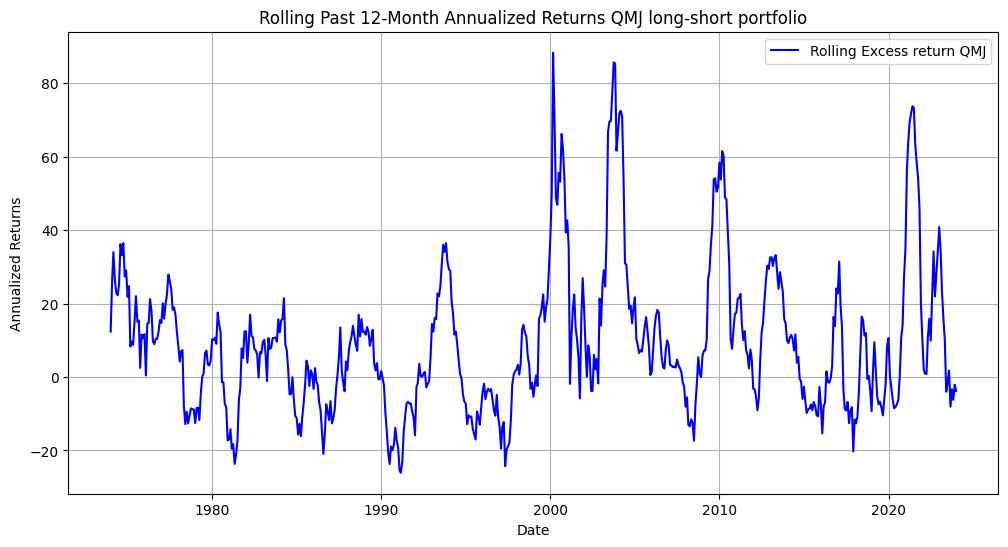

In [44]:
# Plot the values
plt.figure(figsize=(12, 6))

# Plot rolling excess return HML
plt.plot(rolling_stats.index, rolling_stats['Rolling Excess return QMJ'], label='Rolling Excess return QMJ', color='blue')

# Add title and labels
plt.title('Rolling Past 12-Month Annualized Returns QMJ long-short portfolio')
plt.xlabel('Date')
plt.ylabel('Annualized Returns')
plt.legend()

# Show plot
plt.grid(True)
plt.show()

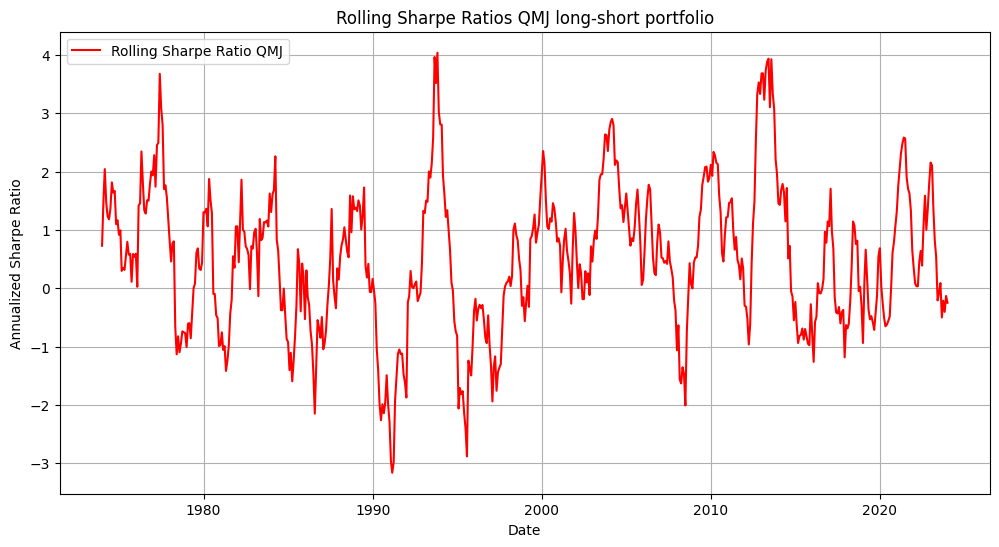

In [45]:
# Plot the values
plt.figure(figsize=(12, 6))

# Plot rolling sharpe ratio HML
plt.plot(rolling_stats.index, rolling_stats['Rolling Sharpe Ratio QMJ'], label='Rolling Sharpe Ratio QMJ', color='red')

# Add title and labels
plt.title('Rolling Sharpe Ratios QMJ long-short portfolio')
plt.xlabel('Date')
plt.ylabel('Annualized Sharpe Ratio')
plt.legend()

# Show plot
plt.grid(True)
plt.show()


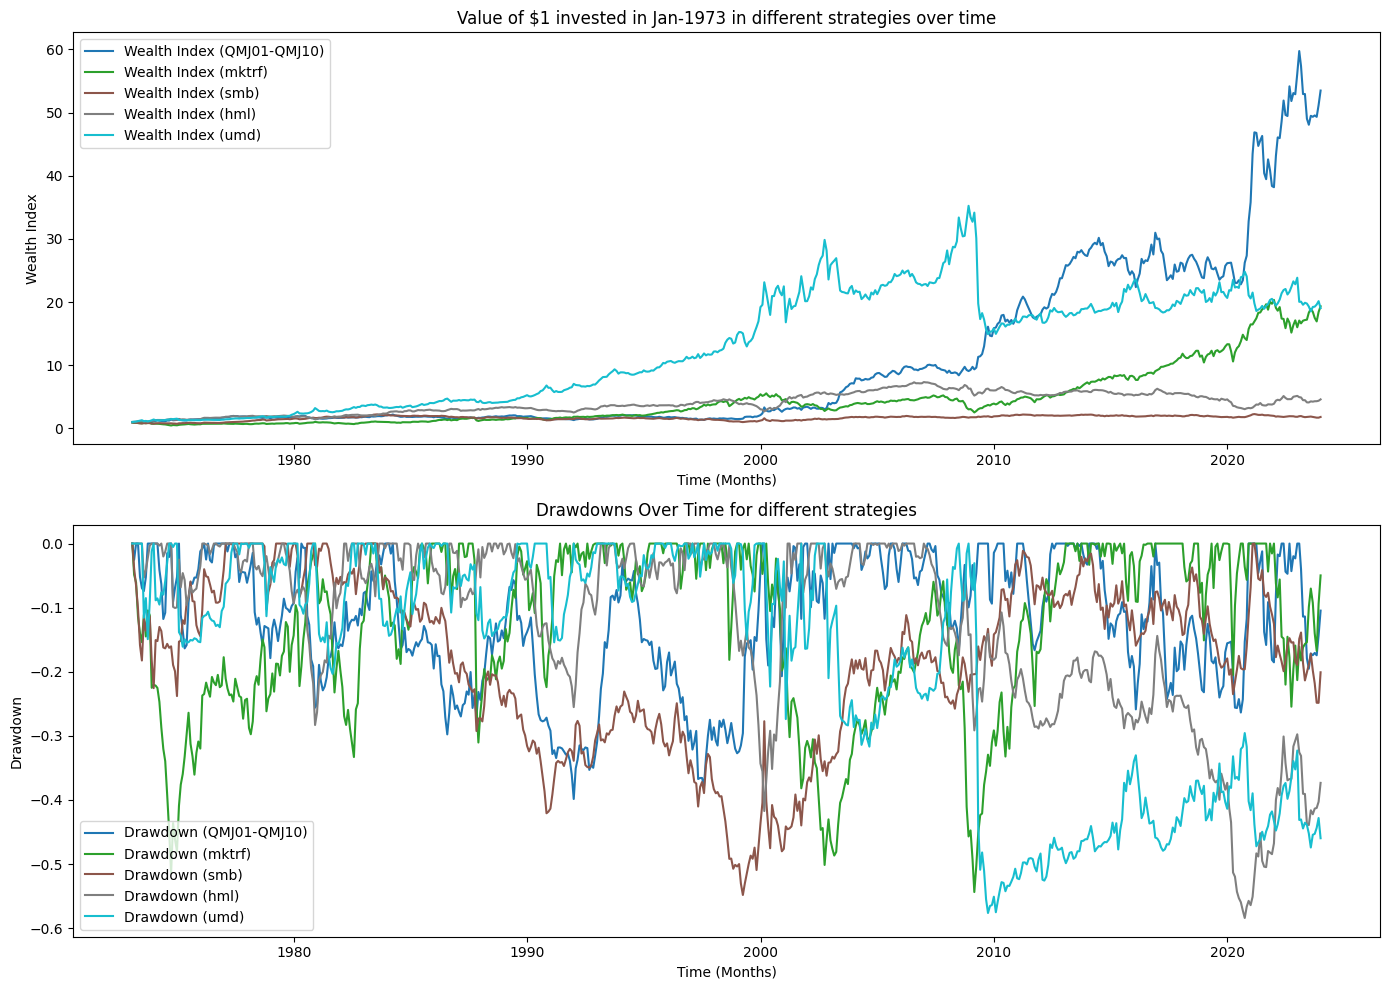

In [46]:

def calculate_wealth_index(monthly_returns):
    monthly_returns = monthly_returns.astype(float)
    # Initialize the wealth index
    initial_wealth = 1.0
    wealth_index = (1 + monthly_returns).cumprod() * initial_wealth
    return wealth_index

def calculate_drawdowns(wealth_index):
    # Calculate the cumulative max
    cumulative_max = wealth_index.cummax()
    # Calculate the drawdowns
    drawdowns = (wealth_index - cumulative_max) / cumulative_max
    max_dd = round(np.min(drawdowns), 2)
    return drawdowns, max_dd

def plot_wealth_and_drawdown(monthly_returns):
    monthly_returns = monthly_returns.astype(float)
    
    # Generate a list of colors for the plots
    colors = plt.cm.get_cmap('tab10', len(monthly_returns.columns))
    
    # Plotting the wealth index and drawdowns
    plt.figure(figsize=(14, 10))

    plt.subplot(2, 1, 1)
    for i, column in enumerate(monthly_returns.columns):
        wealth_index = calculate_wealth_index(monthly_returns[column])
        plt.plot(wealth_index, label=f'Wealth Index ({column})', color=colors(i))
    plt.title('Value of $1 invested in Jan-1973 in different strategies over time')
    plt.xlabel('Time (Months)')
    plt.ylabel('Wealth Index')
    plt.legend()
    plt.grid(False)

    plt.subplot(2, 1, 2)
    max_dds = {}
    for i, column in enumerate(monthly_returns.columns):
        wealth_index = calculate_wealth_index(monthly_returns[column])
        drawdowns, max_dds[column] = calculate_drawdowns(wealth_index)
        plt.plot(drawdowns, label=f'Drawdown ({column})', color=colors(i))
    plt.title('Drawdowns Over Time for different strategies')
    plt.xlabel('Time (Months)')
    plt.ylabel('Drawdown')
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    return max_dds

monthly_returns = pd.merge(df_QMJ['QMJ01-QMJ10'], FF3[['mktrf', 'smb', 'hml', 'umd']], left_index=True, right_index=True, how='inner')

# Plot the wealth index and drawdown
max_drawdowns = plot_wealth_and_drawdown(monthly_returns)

In [47]:
Final_df = pd.merge(FF3_df, QMJ_df.iloc[:, [-1]], left_index=True, right_index=True, how='inner')
for col in Final_df.columns:
    Final_df.loc["Maximum Drawdowns", col] = max_drawdowns[col]
Final_df

,mktrf,smb,hml,umd,QMJ01-QMJ10
Annualized Excess Return,7.13,1.73,3.58,7.00,9.16
Annualized Volatility,16.06,10.60,10.83,15.22,16.75
Skewness,-0.50,0.46,0.07,-1.33,1.66
Annualized Sharpe Ratio,0.44,0.16,0.33,0.46,0.55
Maximum Drawdowns,-0.54,-0.55,-0.58,-0.58,-0.40


#### Calculate alpha of QMJ long-short strategy

In [48]:

# Merge DataFrames to ensure alignment
data = pd.merge(df_QMJ.iloc[:, [-1]], FF3.iloc[:, :4], left_index=True, right_index=True, how='inner')

# Define the independent variables (market, SMB, HML, UMD)
X = data[['mktrf', 'smb', 'hml', 'umd']]
# Add a constant to the independent variables (intercept term)
X = sm.add_constant(X)
# Define the dependent variable (QMJ excess returns)
Y = data['QMJ01-QMJ10']

# Run the regression
model = sm.OLS(Y, X).fit()

# Extract the alpha (intercept) and its t-statistic
alpha = model.params['const']
t_stat_alpha = model.tvalues['const']
annualized_alpha = alpha*12

# Calculate the standard deviation of the residuals
residuals = model.resid
tracking_error = residuals.std()
annualized_tracking_error = tracking_error*np.sqrt(12)

# Calculate the Information Ratio
information_ratio = annualized_alpha / annualized_tracking_error

print(f"Annualized Alpha (intercept): {annualized_alpha:.6f}")
print(f"T-statistic of alpha: {t_stat_alpha:.6f}")
print(f"Annualized Information ratio: {information_ratio:.6f}")

Annualized Alpha (intercept): 0.070611
T-statistic of alpha: 3.572828
Annualized Information ratio: 0.519550


### End of project